IMPORTS

In [182]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import copy

LOADING DATASET

In [183]:
file_path = "Heart_Disease_Prediction.csv"
data_file = pd.read_csv(file_path)

data_file.describe()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000


SEPARATE FEATURES (COLLECTED DATA) AND TARGET (ABSENCE OR PRESENCE OF HEART DISEASE)

In [184]:
X = data_file.drop('Heart Disease', axis=1).values
y = data_file['Heart Disease'].values

ENCODING TARGET VARIABLE (PRESENCE = 1, ABSENCE = 0)

In [185]:
EL = LabelEncoder()
yE = EL.fit_transform(y)
yE.dtype
print(yE)

[1 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 1
 1 0 0 1 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 1 0 1 0 1 1 0 0 0
 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0 0 1 0 1 1 1 0 1 1 0 1
 0 1 0 0 0 1 1 0 1 1 1 1 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1
 1 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 0 1 1 0 0
 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1
 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1
 0 0 1 1 0 1 0 0 0 0 1]


SPLITTING DATA

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, yE, test_size=0.2, random_state=42)

SCALING DATA (STANDARDIZATION) FOR FASTER AND MORE PRECISE PREDICTIONS

In [187]:
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

USING GPU FOR BETTER PERFORMANCE (NVIDIA RTX 4070 in my case)

In [188]:
GPU = torch.device("cuda")
GPU_name = torch.cuda.get_device_name(0)
print(f"{GPU_name}")

NVIDIA GeForce RTX 4070 Laptop GPU


MOVING DATA TO GPU

In [189]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

BUILDING THE MODEL LAYER BY LAYER

In [190]:
input_dim = X_train.shape[1]

model = nn.Sequential(
    nn.Linear(input_dim, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid()
).to(GPU)

TRAINING MODEL WITH EARLY STOPPING

In [191]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 200  
patience = 25
best_loss = np.inf
patience_counter = 0
best_model_weights = None

train_losses = []
val_losses = []

In [ ]:
# Step1 - Training Loop
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    # Step2 - Validation 
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor).item()
        val_losses.append(val_loss) # Save validation loss
    
    # Step3 - Early Stopping Logic ---
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_weights = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}!")
        break
        
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

# Loading the best result
if best_model_weights is not None:
    model.load_state_dict(best_model_weights)
    print("Loaded best model weights.")


Epoch [10/200], Train Loss: 0.5369, Val Loss: 0.4945
Epoch [20/200], Train Loss: 0.3686, Val Loss: 0.3550
Epoch [30/200], Train Loss: 0.3343, Val Loss: 0.3324
Epoch [40/200], Train Loss: 0.3008, Val Loss: 0.3457
Epoch [50/200], Train Loss: 0.2714, Val Loss: 0.3708
Early stopping triggered at epoch 54!
Loaded best model weights.


EVALUATION OF MODEL

In [194]:
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor).cpu().numpy()

y_pred_classes = (y_pred_probs > 0.5).astype(int)   

ACCURACY: 

In [200]:
acc = accuracy_score(y_test, y_pred_classes)
print(f"\nAccuracy: {acc*100:.2f}%")


Accuracy: 87.04%


CLASSIFICATION REPORT

In [196]:
print(classification_report(y_test, y_pred_classes, target_names=['Absence', 'Presence']))

              precision    recall  f1-score   support

     Absence       0.86      0.94      0.90        33
    Presence       0.89      0.76      0.82        21

    accuracy                           0.87        54
   macro avg       0.88      0.85      0.86        54
weighted avg       0.87      0.87      0.87        54



CONFUSION MATRIX

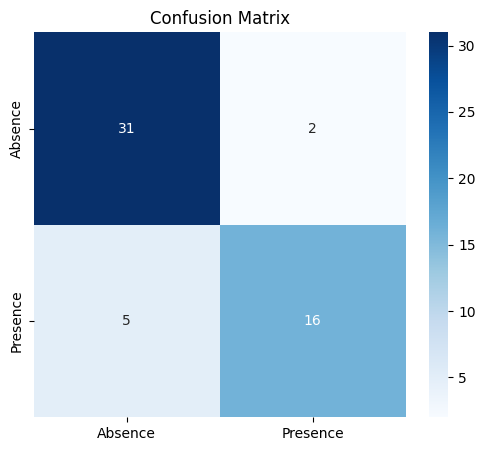

In [197]:
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Absence', 'Presence'], 
            yticklabels=['Absence', 'Presence'])
plt.title('Confusion Matrix')
plt.show()

ROC Curve

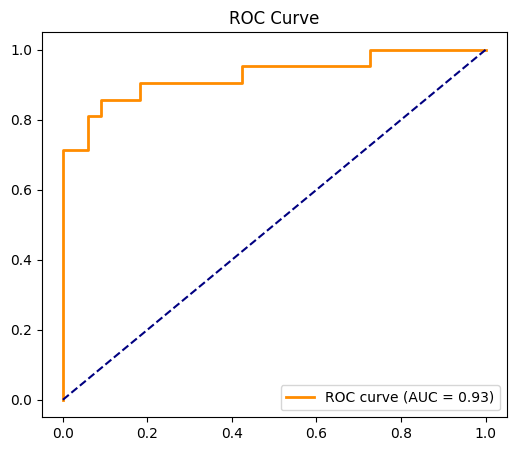

In [198]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend(loc="lower right")
plt.title('ROC Curve')
plt.show()